In [64]:
using JuMP
using Ipopt
#using COPSBenchmark
import Plots
# Goddard Rocket Problem
# Trapezoidal formulation
function rocket_model(nh)
    h_0 = 1.0
    v_0 = 0.0
    m_0 = 1.0
    g_0 = 1.0
    T_c = 3.5
    h_c = 500.0
    v_c = 620.0
    m_c = 0.6

    c = 0.5*sqrt(g_0 * h_0)
    m_f = m_c * m_0
    D_c = 0.5 * v_c * (m_0 / g_0)
    T_max = T_c * m_0 * g_0

    model = Model()

    @variables(model, begin
        1.0 <= h[i=0:nh],          (start=1.0)
        0.0 <= v[i=0:nh],          (start=i/nh*(1.0 - i/nh))
        m_f <= m[i=0:nh] <= m_0,   (start=(m_f - m_0)*(i/nh) + m_0)
        0.0 <= T[i=0:nh] <= T_max, (start=T_max/2.0)
        1e-8 <= step[i=1:nh],               (start=1/nh)
    end)

    @expressions(model, begin
        D[i=0:nh],  D_c*v[i]^2*exp(-h_c*(h[i] - h_0))/h_0
        g[i=0:nh],  g_0 * (h_0 / h[i])^2
        dh[i=0:nh], v[i]
        dv[i=0:nh], (T[i] - D[i] - m[i]*g[i]) / m[i]
        dm[i=0:nh], -T[i]/c
    end)

    @objective(model, Max, h[nh])

    # Dynamics
    @constraints(model, begin
        con_dh[i=1:nh], h[i] == h[i-1] + 0.5 * step[i] * (dh[i] + dh[i-1])
        con_dv[i=1:nh], v[i] == v[i-1] + 0.5 * step[i] * (dv[i] + dv[i-1])
        con_dm[i=1:nh], m[i] == m[i-1] + 0.5 * step[i] * (dm[i] + dm[i-1])
        con_step, sum(step) == 1 
    end)
    # Boundary constraints
    @constraints(model, begin
        h_ic, h[0] == h_0
        v_ic, v[0] == v_0
        m_ic, m[0] == m_0
        m_fc, m[nh] == m_f
    end)

    return model
end

# Solve problem with Ipopt
function Generate_thrust(nhs=nhs)
    Thrusts = [[] for i in range(1,length(nhs))]
    P = Plots.plot(xlabel="Temps", ylabel="Value")
    for i in range(1,length(nhs))
        println(nhs[i])
        nh = nhs[i]
        model = rocket_model(nh)
        JuMP.set_optimizer(model, Ipopt.Optimizer)
        JuMP.optimize!(model)
        T_value = value.(model[:T]);
        T_Array = Array(T_value);
        Thrusts[i] = T_Array
        Plots.plot!(LinRange(0,0.2,length(T_Array)),T_Array,label="T values for nh = $nh")
    end
    print("Loop done")
    return P
end


Generate_thrust (generic function with 2 methods)

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     2204
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4900

Total number of variables............................:      504
                     variables with only lower bounds:      302
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      305
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+00 3.50e-02 1.65e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

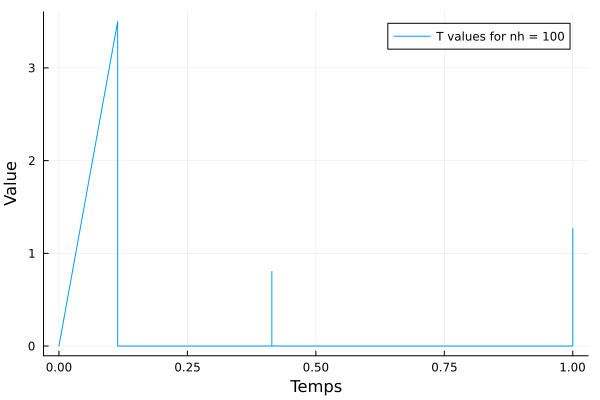

In [77]:
function Generate_thrust(nhs=nhs)
    Thrusts = [[] for i in range(1,length(nhs))]
    Steps = [[] for i in range(1,length(nhs))]
    
    P = Plots.plot(xlabel="Temps", ylabel="Value")
    for i in range(1,length(nhs))
        nh = nhs[i]
        model = rocket_model(nh)
        JuMP.set_optimizer(model, Ipopt.Optimizer)
        JuMP.optimize!(model)
        Thrusts[i] = Array(value.(model[:T]))
        Steps[i] = [0;cumsum(Array(value.(model[:step])))]
        Plots.plot!(Steps[i],Thrusts[i],label="T values for nh = $nh")
    end
    print("Loop done")
    return P
end
p = Generate_thrust([100]);

# p1 = Plots.plot(steps,title = "pas de chaque indice", ylabel = "sec",label = "step")
# p2 = Plots.plot(Thrusts,title = "Thrust de chaque indice", ylabel = "Value",label = "T Value")
# Plots.plot(p1,p2,Layout = (1,2))

In [ ]:
MModel = rocket_model(10000)
JuMP.set_optimizer(MModel,Ipopt.Optimizer)
JuMP.optimize!(MModel)
steps = Array(JuMP.value.(MModel[:step]))
Thrust = Array(JuMP.value.(MModel[:T]))

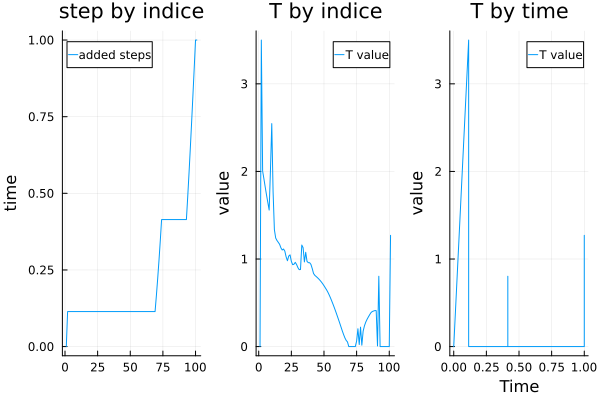

In [94]:
p1 = Plots.plot([0;cumsum(steps)],title = "step by indice",ylabel = "time",label = "added steps");
p2 = Plots.plot(Thrust,title = "T by indice",ylabel = "value",label = "T value");
p3 = Plots.plot([0;cumsum(steps)],Thrust,title = "T by time",ylabel = "value",label = "T value",xlabel = "Time")
Plots.plot(p1,p2,p3,layout = (1,3))

In [71]:
[0;cumsum(steps)]

101-element Vector{Float64}:
 0.0
 0.11428571634683919
 0.11428571634879826
 0.11428571635166952
 0.11428571635477422
 0.11428571635812386
 0.11428571636172793
 0.11428571636560353
 0.11428571636914166
 0.11428571637196551
 ⋮
 0.4143211550766132
 0.4876499712761755
 0.5652912717273344
 0.6468915952208769
 0.731921398972659
 0.8196856725589008
 0.9093543457251849
 0.9999999999890361
 0.9999999999978177